In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import metrics
import xgboost as xgb
import tensorflow as tf
import keras
import datetime

In [2]:
# import data
train = pd.read_csv(r'C:\Users\Lenny\Documents\Github\Kaggle\BikeSharingDemand\train.csv')
test = pd.read_csv(r'C:\Users\Lenny\Documents\Github\Kaggle\BikeSharingDemand\test.csv')
sample = pd.read_csv(r'C:\Users\Lenny\Documents\Github\Kaggle\BikeSharingDemand\sampleSubmission.csv')

In [3]:
# process datetime
def processDatetime(df):
    df['year'] = df['datetime'].apply(lambda x: int(x.split('-')[0]))
    df['month'] = df['datetime'].apply(lambda x: int(x.split('-')[1]))
    df['day'] = df['datetime'].apply(lambda x: int(x.split('-')[2].split(' ')[0]))
    df['hour'] = df['datetime'].apply(lambda x: int(x.split('-')[2].split(' ')[1].split(':')[0]))
    df['weekday'] = df.loc[:, ['year', 'month', 'day']].apply(lambda x: datetime.datetime(x['year'], x['month'], x['day']).weekday(), axis=1)
processDatetime(train)
processDatetime(test)

In [4]:
# basic linear regression
from sklearn.preprocessing import OneHotEncoder

def encodeColumns(df, c):
    enc = OneHotEncoder(sparse_output=False)
    enc.fit(df[c].values[:, None])
    return pd.concat(
        [
            df,
            pd.DataFrame(
                data = enc.transform(df[c].values[:, None]), 
                columns = [c + '_' + str(x) for x in df[c].unique()]
            )
        ], axis=1)

train = encodeColumns(train, 'weather')
train = encodeColumns(train, 'weekday')
train = encodeColumns(train, 'month')
train = encodeColumns(train, 'hour')

test = encodeColumns(test, 'weather')
test = encodeColumns(test, 'weekday')
test = encodeColumns(test, 'month')
test = encodeColumns(test, 'hour')

cols = ['holiday', 'workingday'] + [c for c in train.columns if c.startswith('weekday_')]
for i, c1 in enumerate(cols):
    for j, c2 in enumerate(cols):
        if (j > i) and not (c1.startswith('weekday_') and c2.startswith('weekday_')):
            train[c1+'_'+c2] = train[c1]*train[c2]
            test[c1+'_'+c2] = test[c1]*test[c2]


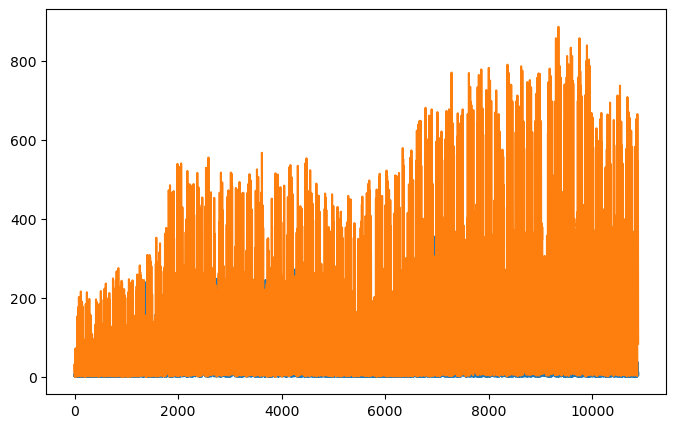

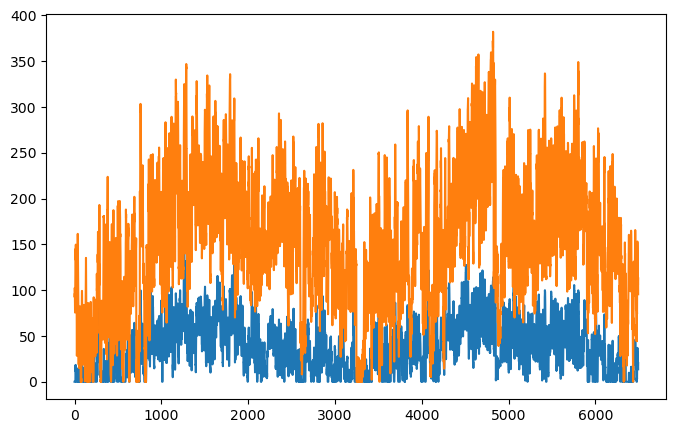

In [5]:
# linear regression
ind_cols = ['season', 'holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed']
ind_cols += [c for c in train.columns if any([c.startswith(s) for s in ['weather_', 'weekday_', 'month_', 'holiday_', 'workingday_']])]
dep_cols = ['casual', 'registered']
x_train = train.loc[:, ind_cols]
y_train = train.loc[:, dep_cols]
x_test = test.loc[:, ind_cols]

model = linear_model.ElasticNet(alpha=0.01)
model.fit(x_train, y_train)

y_test = model.predict(x_test)
y_test[y_test < 0] = 0
y_test = pd.DataFrame(
    y_test,
    columns = y_train.columns)
y_test['count'] = y_test.sum(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(y_train['casual'])
ax.plot(y_train['registered'])

fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(y_test['casual'])
ax.plot(y_test['registered'])

output = y_test.loc[:, ['count']]
output.insert(0, 'datetime', test['datetime'])
output.to_csv(r'C:\Users\Lenny\Documents\Github\Kaggle\BikeSharingDemand\submission.csv', index=False)

In [329]:
# compute averages of all quantitative columns per day
cols = ['season', 'holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed']
cols += [c for c in train.columns if any([c.startswith(s) for s in ['weather_', 'weekday_', 'month_', 'holiday_', 'workingday_']])]
dep_cols = ['casual', 'registered']
train_avg = train.groupby(['year', 'month', 'day'])[cols + dep_cols].mean()
test_avg = test.groupby(['year', 'month', 'day'])[cols].mean()

# use all columns to model the daily avg
x, y = train_avg.loc[:, cols], train_avg.loc[:, dep_cols]
daily_avg_model = linear_model.LinearRegression()
daily_avg_model.fit(x, y)
y_pred = pd.DataFrame(
    data = daily_avg_model.predict(x),
    columns = dep_cols,
    index = x.index)
y_pred[y_pred < 0] = 0
y_test_pred = pd.DataFrame(
    data = daily_avg_model.predict(test_avg.loc[:, cols]),
    columns = dep_cols,
    index = test_avg.index)
y_test_pred[y_test_pred < 0] = 0

In [344]:
# compute the rolling N-day mean over quantitative variables, we'll use this for anomaly detection
def movmean(v, n):
    return np.convolve(v, np.ones(n), 'same') / n

# lets try 14d
train_mavg = train_avg.loc[:, cols]
test_mavg = test_avg.loc[:, cols]

res_cols = ['temp', 'atemp', 'humidity', 'windspeed']
res_cols += [c for c in cols if any([s in c for s in ['weather', 'holiday']])]
for c in res_cols:
    train_mavg[c] = movmean(train_mavg[c], 14)
    test_mavg[c] = movmean(test_mavg[c], 14)
    
# compute residuals between hourly and N-day averages
x_res = train.loc[:, cols + ['year', 'month', 'day']]
x_res = x_res.set_index(['year', 'month', 'day'])
x_test_res = test.loc[:, cols + ['year', 'month', 'day']]
x_test_res = x_test_res.set_index(['year', 'month', 'day'])
for c in res_cols:
    x_res[c + '_res'] = train.set_index(['year', 'month', 'day'])[c] - train_mavg[c]
    x_test_res[c + '_res'] = test.set_index(['year', 'month', 'day'])[c] - test_mavg[c]
    
# get the dependent variable residuals to predict
y_res = train.loc[:, dep_cols + ['year', 'month', 'day']].set_index(['year', 'month', 'day']) - y_pred
    
# train another linear model to predict the residuals using signals and residuals
res_model = linear_model.LinearRegression()
res_model.fit(x_res, y_res)
y_res_pred = pd.DataFrame(
    data = res_model.predict(x_res),
    columns = dep_cols,
    index = x_res.index)
y_res_test_pred = pd.DataFrame(
    data = res_model.predict(x_test_res),
    columns = dep_cols,
    index = x_test_res.index)

# set output
output = (y_test_pred + y_res_test_pred).reset_index(drop=True)
output[output < 0] = 0
output['count'] = output.sum(axis=1)
output.insert(0, 'datetime', test['datetime'])
output.loc[:, ['datetime', 'count']].to_csv(r'C:\Users\Lenny\Documents\Github\Kaggle\BikeSharingDemand\submission.csv', index=False)